In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class Cluster:
    def __init__(self, label, columns):
        self.label = label
        self.columns = columns
        
        X = data.all_food[columns.keys()]
        self.X = X.dropna()
        self.na_count = len(X) - len(self.X)

        self.k = self.elbow()

        self.clf = KMeans(n_clusters=self.k)
        self.clf.fit(self.X)

        self.labels = pd.Series(self.clf.labels_, index=self.X.index)
        self.labels.name = "Cluster"

        # Right join drops things not in labels
        self.data = data.all.join(self.labels, how="right")

    def elbow(self, ks=range(2,10)):
        clfs = [KMeans(n_clusters=k).fit(self.X) for k in ks]
        inertias = [clf.inertia_ for clf in clfs]
        
        slopes = [inertias[k - min(ks)] - inertias[k + 1 - min(ks)] for k in range(min(ks), max(ks) - 1)]

        fractions =  [slopes[i + 1] / slopes[i] for i in range(0, len(slopes) - 1)]

        optimal_k = np.argmin(fractions) + min(ks) + 1

        # Plot it.
        plt.plot(ks, inertias, 'o-')

        # Highlight optimal point.
        radius = 15
        point = (optimal_k, inertias[optimal_k - min(ks)])
        plt.plot(point[0], point[1], 'o', ms=radius * 2, mec='g', mfc='none', mew=2)
        plt.annotate('Optimal K={}'.format(optimal_k), xy=point, xytext=(40, 60),
            textcoords='offset points',
            color='darkgreen',
            size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=1,head_length=0.8',
                facecolor='g',
                shrinkA=radius ,
                shrinkB=radius * 1.3,
                edgecolor='g',
            ),
        )

        # Title and labels.
        plt.title("Optimal Number of Clusters for {}".format(self.label))
        plt.ylabel("Sum of Squared Error")
        plt.xlabel("Number of Clusters (K)")

        # Show it.
        plt.show()

        return optimal_k

    @property
    def clusters(self):
        df = pd.DataFrame(self.clf.cluster_centers_,
            columns=list(self.columns.values())
        ).round(3)
        df.index.name = "Cluster"

        df.insert(0, "Number of Counties", self.labels.value_counts())

        df = df.join(self.data.groupby("Cluster").mean()[[
            "Population Estimate, 2016",
            "Percent of adults with a bachelor's degree or higher, 2014-18",
        ]])

        df = df.rename(columns={
            "Population Estimate, 2016": "Average Population",
            "Percent of adults with a bachelor's degree or higher, 2014-18": "Average Bachelor's Degree %",
        })

        df["Average Population"] = df["Average Population"].round()
        df["Average Bachelor's Degree %"] = df["Average Bachelor's Degree %"].round(1)

        return df

    def counties_in_cluster(self, cluster):
        df = self.data.loc[self.data["Cluster"] == cluster]
        df = df[["State", "County", "Population Estimate, 2016",]]
        return df.rename(columns={ "Population Estimate, 2016": "Population" })

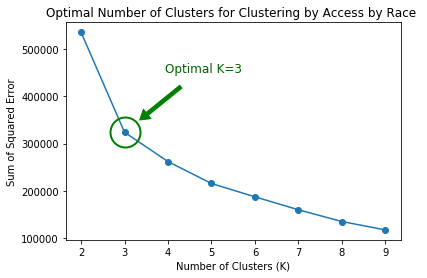

,Number of Counties,"White, low access to store (%), 2015","Black, low access to store (%), 2015","Hispanic ethnicity, low access to store (%), 2015","Asian, low access to store (%), 2015","American Indian or Alaska Native, low access to store (%), 2015","Hawaiian or Pacific Islander, low access to store (%), 2015",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,
0,1952,9.879,2.065,0.929,0.194,0.543,0.015,112377.0,20.7
1,131,85.448,0.711,10.235,0.300,1.157,0.038,2711.0,20.7
2,1038,27.740,1.683,3.043,0.347,1.124,0.026,99186.0,23.4


In [18]:
race = Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to store (%), 2015",
    "PCT_LACCESS_BLACK15": "Black, low access to store (%), 2015",
    "PCT_LACCESS_HISP15": "Hispanic ethnicity, low access to store (%), 2015",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to store (%), 2015",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to store (%), 2015",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to store (%), 2015",
})
race.clusters

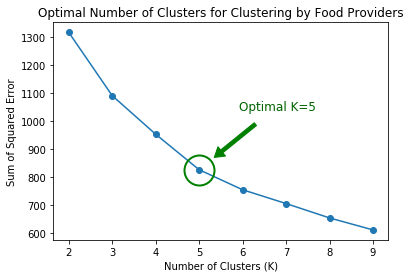

,Number of Counties,"Grocery stores/1,000 pop, 2014","Supercenters & club stores/1,000 pop, 2014","Convenience stores/1,000 pop, 2014","Specialized food stores/1,000 pop, 2014","Fast-food restaurants/1,000 pop, 2014","Full-service restaurants/1,000 pop, 2014","Farmers' markets/1,000 pop, 2016",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,,
0,1083,0.231,0.014,0.657,0.030,0.396,0.424,0.050,29218.0,16.1
1,77,0.509,0.016,0.887,0.159,1.075,2.865,0.147,48355.0,33.1
2,451,0.444,0.012,0.774,0.068,0.532,1.350,0.109,22694.0,22.0
3,1525,0.193,0.023,0.481,0.057,0.690,0.740,0.044,181968.0,24.7
4,4,1.342,0.000,2.295,0.000,1.747,8.836,0.342,787.0,36.2


In [26]:
choice = Cluster("Clustering by Food Providers", {
    "GROCPTH14": "Grocery stores/1,000 pop, 2014",
    "SUPERCPTH14": "Supercenters & club stores/1,000 pop, 2014",
    "CONVSPTH14": "Convenience stores/1,000 pop, 2014",
    "SPECSPTH14": "Specialized food stores/1,000 pop, 2014",
    "FFRPTH14": "Fast-food restaurants/1,000 pop, 2014",
    "FSRPTH14": "Full-service restaurants/1,000 pop, 2014",
    "FMRKTPTH16": "Farmers' markets/1,000 pop, 2016",
})
choice.clusters

In [27]:
choice.counties_in_cluster(4)

,State,County,Population
8053,Colorado,Hinsdale,788
8079,Colorado,Mineral,732
8111,Colorado,San Juan,694
38007,North Dakota,Billings,934
